In [10]:
import os
import time
import shutil
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import model_from_json
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ModelCheckpoint, CSVLogger
from anomaly_detection.preprocessing import create_train, create_test
from anomaly_detection.visualize import analyze_and_plot_results
from anomaly_detection.architecture import create_model_simple_LSTM, create_model_simple_GRU, create_model_simple_CuDNNLSTM, create_model_simple_CuDNNGRU, create_model_bidirectional_CuDNNLSTM, create_model_CuDNNLSTM, create_model_LSTM, create_model_Conv1D, create_model_CuDNNLSTM_Conv1D, create_model_LSTM_Conv1D

# 1. Configure the hyperparameters

In [12]:
# Reproducibility
np.random.seed(1234)

# 1 Day as 96 * 15m
time_window_size = 96

# Used for data augmentation, where we randomly duplicate certain amount of training data, this is the ratio we use
duplication_ratio = 0.04

# 20 percent of training data is used as validation set to avoid overfitting
validation_split = 0.2

# Number of epoch and the batch size
epochs = 30
batch_size = 128

# Number of neurons within different LSTM layers
layers = {
    'input': 1,
    'hidden1': 64,
    'hidden2': 256,
    'hidden3': 100,
    'output': 1
}

# Make sure output dir exists
input_csv = "ammonia_train.csv"
output_dir = 'results'

if not os.path.exists(output_dir,):
    os.makedirs(output_dir)

# 2. Training the neural network, which may take a while. Or skip this step, and use the pre-trained model directly in step 3

In [13]:
# Measure the training time
global_start_time = time.time()

# Input dataset, which contains two columns - timestamp and value
df = pd.read_csv(os.path.join('datasets/train', input_csv))

"""
X represents each row for training sequence
y represents the target we will later predict
"""

data = df.value.values.astype("float64")

X_train, y_train = create_train(
    data=data, time_window_size=time_window_size,
    duplication_ratio=duplication_ratio)

# Create LSTM model
model = create_model_LSTM(
    time_window_size=time_window_size, layers=layers)

# The learned parameters (weights and biases) are saved as HDF5
checkpoint = ModelCheckpoint(
    filepath='models/ammonia/best_model.h5', monitor='val_loss', save_best_only=True)

# Training stops when overfitting starts to occur
early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='auto')

# Training history is saved, which measures the decrease of loss function
csv_logger = CSVLogger('models/ammonia/history.csv', append=True, separator=',')

# Training the models
history_callback = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                             validation_split=validation_split, verbose=1, callbacks=[checkpoint, csv_logger, early_stopping])

# Save the training history
history_csv_path = os.path.join('models/ammonia/history.csv')

# Serialize the network strcture as JSON, reuse it when resume the training
model_json = model.to_json()
with open("models/ammonia/model.json", "w") as json_file:
    json_file.write(model_json)

# Display the training time
print('Training duration (s) : ', time.time() - global_start_time)

Total readings: 768
Creating train data...
Mean of train data : 18.245006535002027
Train data shape  : (672, 96)
nb_duplicates: 26.88
Shape X_train (8657, 95)
Train on 6925 samples, validate on 1732 samples
Epoch 1/30
6925/6925 [==============================] - 3s 387us/step - loss: 0.2288 - val_loss: 0.0384
Epoch 2/30
6925/6925 [==============================] - 2s 226us/step - loss: 0.0702 - val_loss: 0.0407
Epoch 3/30
6925/6925 [==============================] - 2s 223us/step - loss: 0.0567 - val_loss: 0.0231
Epoch 4/30
6925/6925 [==============================] - 2s 225us/step - loss: 0.0392 - val_loss: 0.0225
Epoch 5/30
6925/6925 [==============================] - 2s 223us/step - loss: 0.0342 - val_loss: 0.0121
Epoch 6/30
6925/6925 [==============================] - 2s 225us/step - loss: 0.0323 - val_loss: 0.0113
Epoch 7/30
6925/6925 [==============================] - 2s 222us/step - loss: 0.0262 - val_loss: 0.0081
Epoch 8/30
6925/6925 [==============================] - 2s 227us/

# 3. Detect anomalies on test dataset

Total readings: 2400
Creating test data...
Mean of test data :  10.900808001581142
test data shape  :  (2304, 96)
Shape X_test (2304, 95)
Loaded model from disk
Predicting...
Reshaping...
Saving...
Plotting...


C:\Users\xiwan\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Results saved in: results


C:\Users\xiwan\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


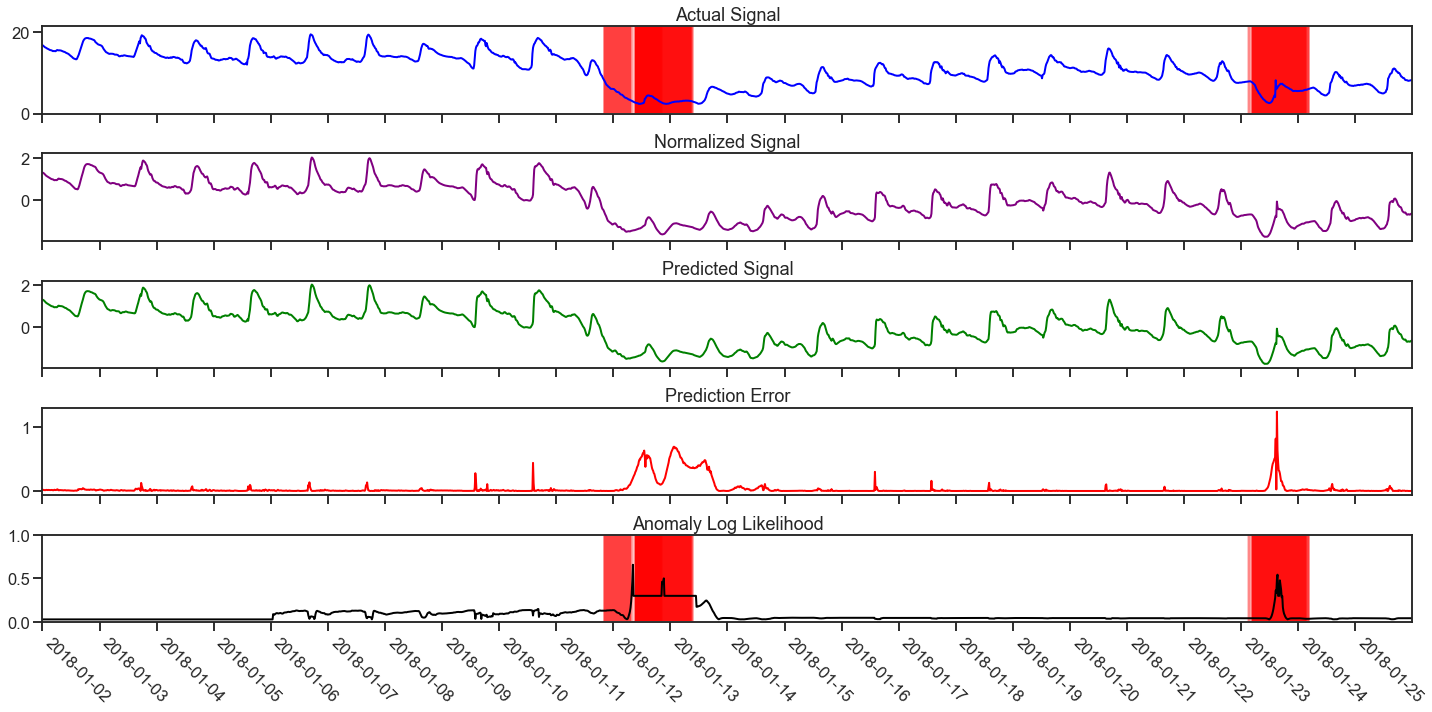

In [15]:
# Test dataset contains tow columns - timestamp and value
input_csv = 'ammonia_2018_01.csv' 
df = pd.read_csv(os.path.join('datasets/test/ammonia', input_csv))

"""
X represents each row for training sequence
y represents the target we will later predict
"""
data = df.value.values.astype("float64")
y_true = data[time_window_size:]
timestamps = df.timestamp.values[time_window_size:]
X_test, y_test = create_test(
    data=data, time_window_size=time_window_size)

# Load network structure from JSON file and create model
json_file = open('models/ammonia/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load the stored predictive model
loaded_model.load_weights("models/ammonia/best_model.h5")
print("Loaded model from disk")

# Predict values and save the results
print("Predicting...")
y_pred = loaded_model.predict(X_test, batch_size=batch_size)
print("Reshaping...")
y_pred = np.reshape(y_pred, (y_pred.size,))

# Save the predicted results to disk as csv file
print("Saving...")
results_csv_path = os.path.join(output_dir, input_csv)
df = pd.DataFrame(data={'timestamps': timestamps, 'y_true': y_true,
                        'y_test': y_test, 'y_pred': y_pred})
df.to_csv(results_csv_path, index=False)

# Calculate the anomaly score based on the prediction error
print("Plotting...")
analyze_and_plot_results(results_csv_path)
print("Results saved in:", output_dir)

# Weather Condition in January 2018

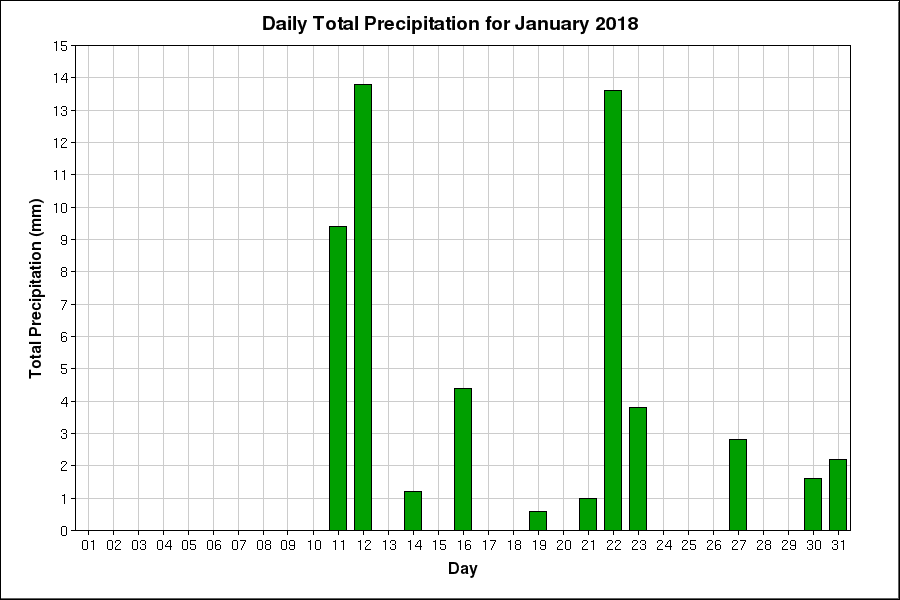

Total readings: 2592
Creating test data...
Mean of test data :  13.581132353822843
test data shape  :  (2496, 96)
Shape X_test (2496, 95)
Loaded model from disk
Predicting...
Reshaping...
Saving...
Plotting...


C:\Users\xiwan\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Results saved in: results


C:\Users\xiwan\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


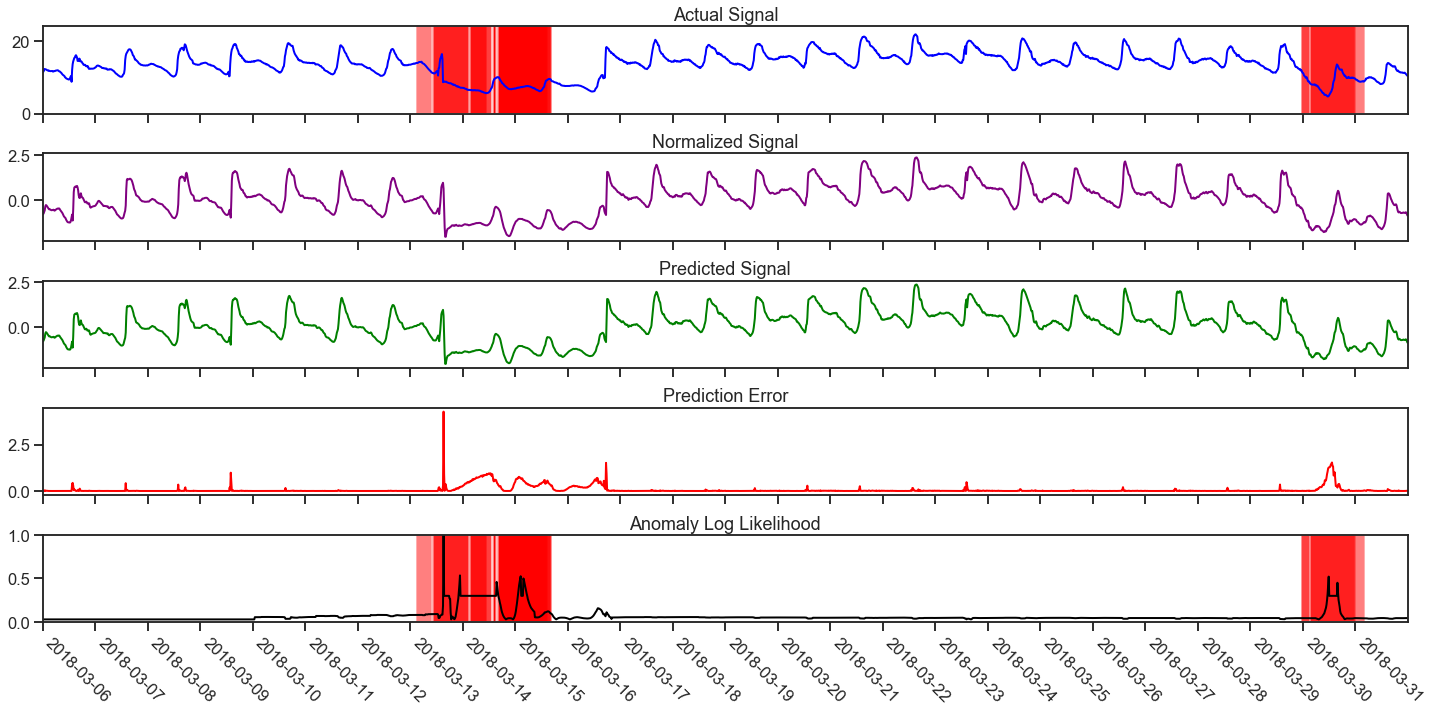

In [16]:
# Test dataset contains tow columns - timestamp and value
input_csv = 'ammonia_2018_03.csv' 
df = pd.read_csv(os.path.join('datasets/test/ammonia', input_csv))

"""
X represents each row for training sequence
y represents the target we will later predict
"""
data = df.value.values.astype("float64")
y_true = data[time_window_size:]
timestamps = df.timestamp.values[time_window_size:]
X_test, y_test = create_test(
    data=data, time_window_size=time_window_size)

# Load network structure from JSON file and create model
json_file = open('models/ammonia/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load the stored predictive model
loaded_model.load_weights("models/ammonia/best_model.h5")
print("Loaded model from disk")

# Predict values and save the results
print("Predicting...")
y_pred = loaded_model.predict(X_test, batch_size=batch_size)
print("Reshaping...")
y_pred = np.reshape(y_pred, (y_pred.size,))

# Save the predicted results to disk as csv file
print("Saving...")
results_csv_path = os.path.join(output_dir, input_csv)
df = pd.DataFrame(data={'timestamps': timestamps, 'y_true': y_true,
                        'y_test': y_test, 'y_pred': y_pred})
df.to_csv(results_csv_path, index=False)

# Calculate the anomaly score based on the prediction error
print("Plotting...")
analyze_and_plot_results(results_csv_path)
print("Results saved in:", output_dir)

# Weather Condition in March 2018

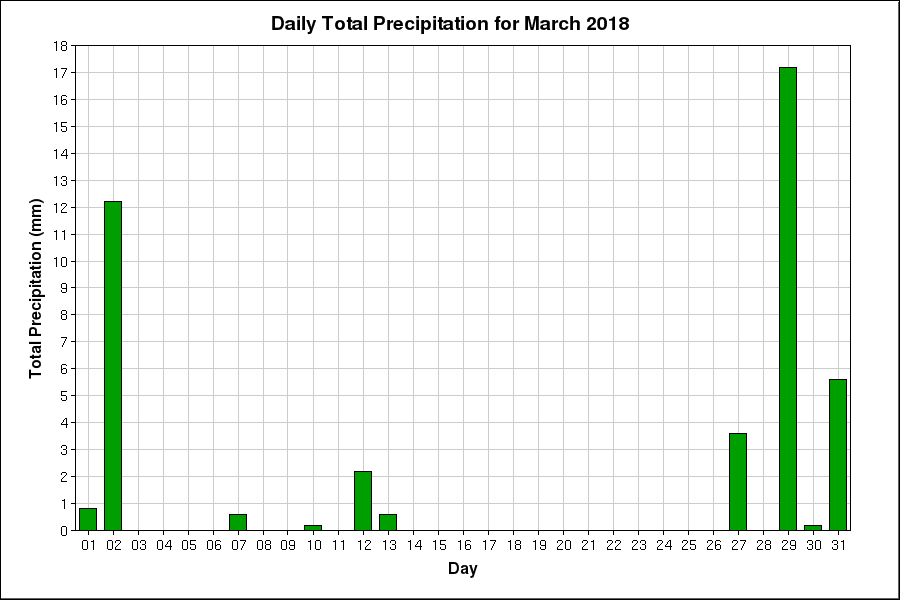

# The first red zone which occurred in dry days was the "real" faulty data